In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/Classroom/Brainster/IMG.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/IMG/right_2021_07_13_22_38_52_665.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_754.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_845.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_52_934.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_024.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_113.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_206.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_294.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_385.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_472.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_563.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_653.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_740.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_829.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_53_921.jpg  
  inflating: data/IMG/right_2021_07_13_22_38_54_008.jpg  
  inflating: data/IMG

# **Importing Libraries**

In [3]:
import numpy as np
import pandas as pd
import os
import cv2 as cv 
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import random
from sklearn.utils import shuffle
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import core, convolutional, pooling
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers, backend

# **Dataset loading and preprocessing:**

In [4]:
dataset = pd.read_csv('data/driving_log.csv', names= ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

In [5]:
dataset['center'][0]

'D:\\simulacii\\IMG\\center_2021_07_13_22_33_52_335.jpg'

In [6]:
dataset.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'], dtype='object')

In [7]:
copy_dataset = dataset.copy()

copy_dataset['center'] = copy_dataset['center'].apply(lambda x : x.split('\\')[3])
copy_dataset['left'] = copy_dataset['left'].apply(lambda x : x.split('\\')[3])
copy_dataset['right'] = copy_dataset['right'].apply(lambda x : x.split('\\')[3])

In [8]:
copy_dataset.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_07_13_22_33_52_335.jpg,left_2021_07_13_22_33_52_335.jpg,right_2021_07_13_22_33_52_335.jpg,0.0,0.0,0,0.000007
1,center_2021_07_13_22_33_52_434.jpg,left_2021_07_13_22_33_52_434.jpg,right_2021_07_13_22_33_52_434.jpg,0.0,0.0,0,0.000010
2,center_2021_07_13_22_33_52_527.jpg,left_2021_07_13_22_33_52_527.jpg,right_2021_07_13_22_33_52_527.jpg,0.0,0.0,0,0.000007
3,center_2021_07_13_22_33_52_595.jpg,left_2021_07_13_22_33_52_595.jpg,right_2021_07_13_22_33_52_595.jpg,0.0,0.0,0,0.000009
4,center_2021_07_13_22_33_52_691.jpg,left_2021_07_13_22_33_52_691.jpg,right_2021_07_13_22_33_52_691.jpg,0.0,0.0,0,0.000007


> **Definition of image read function**





In [9]:
def read_image(path_):
  final_path = os.path.join("data/IMG", path_)
  picture = cv.imread(final_path)
  picture_rgb = cv.cvtColor(picture, cv.COLOR_BGR2RGB)
  return picture_rgb

inputs = []
targets = []
for c1, c2, c3, angle in zip(copy_dataset['center'], copy_dataset['left'], copy_dataset['right'], copy_dataset['steering']):
   inputs.append(c1)
   targets.append(angle)
   inputs.append(c2)
   targets.append(angle)
   inputs.append(c3)
   targets.append(angle)

In [10]:
print(len(inputs))
print(len(targets))

26037
26037


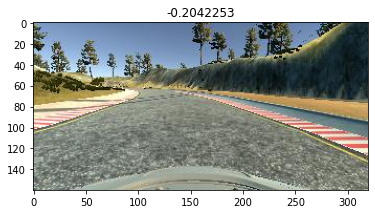

In [11]:
plt.imshow(read_image(inputs[225]))
plt.title(targets[225])
plt.show()

# **Definition of image augmentation functions**



Function for croping the upper segment of the picture

In [12]:
def crop(img, crop_size=60):

    new_slika = img.copy()
    cropped = new_slika[crop_size:, :, :]

    return cropped

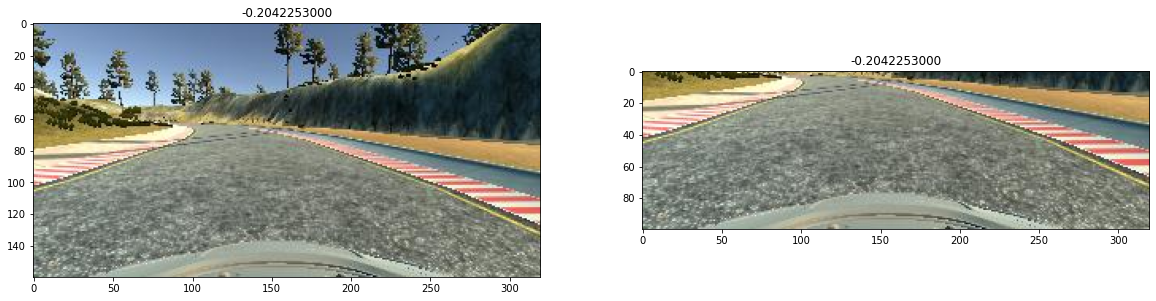

In [13]:
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(inputs[225]))
plt.title('{0:.10f}'.format(targets[225]))
f.add_subplot(1,2, 2)
plt.imshow(crop(read_image(inputs[225])))
plt.title('{0:.10f}'.format(targets[225]))
plt.show(block=True)

> **Function that returns flipped image**


In [14]:
def flip_image(img, steering_angle):
    flip_img = cv.flip(img, 1)
    steering_angle = steering_angle * (-1)
    return flip_img, steering_angle

In [15]:
original_image = read_image(inputs[225])
original_angle = targets[225]

In [16]:
fliped_image, fliped_angle = flip_image(original_image, original_angle)

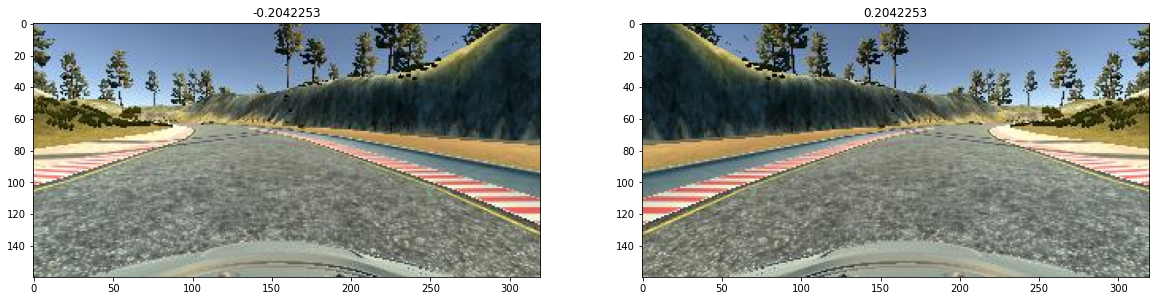

In [17]:
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(inputs[225]))
plt.title(targets[225])
f.add_subplot(1,2, 2)
plt.imshow(fliped_image)
plt.title(fliped_angle)

plt.show(block=True)

Function for changing image brithness

In [18]:
def change_image_brightness(img, s_low=0.3, s_high=0.7):
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

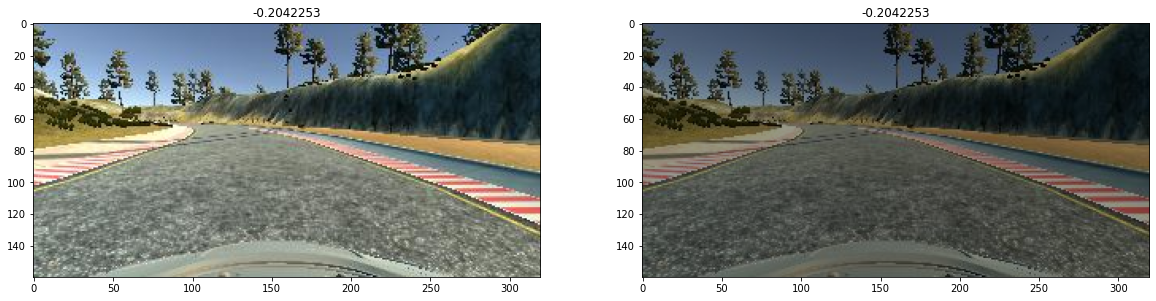

In [19]:
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(inputs[225]))
plt.title(targets[225])
f.add_subplot(1,2, 2)
plt.imshow(change_image_brightness(read_image(inputs[225])))
plt.title(targets[225])
plt.show(block=True)

Function for adding random shadow

In [20]:
def add_random_shadow(img, w_low=0.5, w_high=0.9):
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)
    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv.fillPoly(mask, poly, (0, 0, 0))
    
    return cv.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

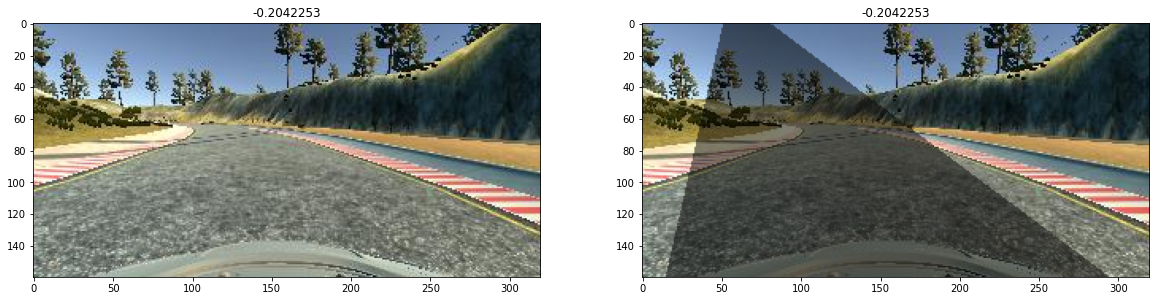

In [21]:
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(inputs[225]))
plt.title(targets[225])
f.add_subplot(1,2, 2)
plt.imshow(add_random_shadow(read_image(inputs[225])))
plt.title(targets[225])
plt.show(block=True)

In [22]:
def random_noise(image,prob=0.05):

    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

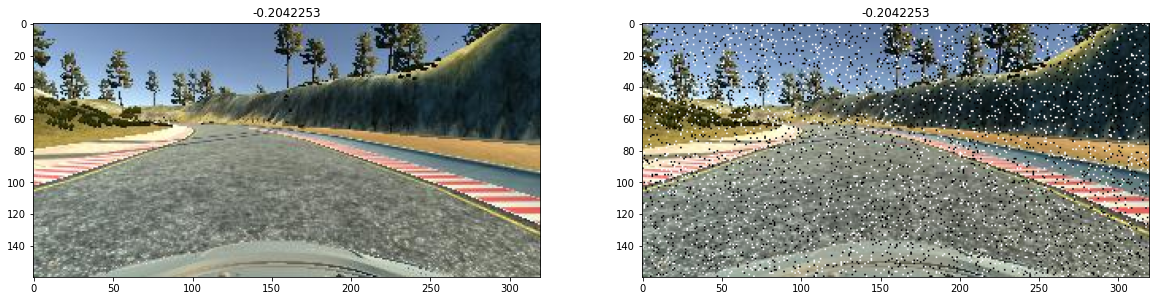

In [23]:
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(20)
f.add_subplot(1,2, 1)
plt.imshow(read_image(inputs[225]))
plt.title(targets[225])
f.add_subplot(1,2, 2)
plt.imshow(random_noise(read_image(inputs[225])))
plt.title(targets[225])
plt.show(block=True)

# **Generator**

Image augmentation function

In [24]:
def augment_image(img, angle, p=1.0):
    aug_img = img
    
    if np.random.random_sample() <= p: 
        aug_img, angle = flip_image(aug_img, angle)
     
    if np.random.random_sample() <= p:
        aug_img = change_image_brightness(aug_img)
    
    if np.random.random_sample() <= p: 
        aug_img = add_random_shadow(aug_img)

    if np.random.random_sample() <= p:
        aug_img = random_noise(aug_img)
            
    return aug_img, angle

Image generator function

In [25]:
def generator(inputs, targets, batch_size = 32, is_training=True):
    images = inputs
    global ang
    while True:
      for i in range(0, len(images), batch_size):
          X_batch = []
          target_batch  = []
          for image, target in zip(images[i:i+batch_size], targets[i:i+batch_size]):
              slika = read_image(image)
              slika = crop(slika)
              if is_training:
                slika, ang = augment_image(slika, target, p=0.5)

              X_batch.append(slika)
              target_batch.append(ang)
      
          yield np.array(X_batch), np.array(target_batch)

In [26]:
train_generator = generator(inputs, targets, 64)
valid_generator = generator(inputs, targets, 64, is_training=False)

In [ ]:
batch_data = next(train_generator)

In [ ]:
list(map('{0:.20f}'.format,batch_data[1]))

['-0.00000000000000000000',
 '0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '0.00000000000000000000',
 '0.00000000000000000000',
 '0.00000000000000000000',
 '-0.00000000000000000000',
 '0.00000000000000000000',
 '0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '0.00000000000000000000',
 '0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '0.00000000000000000000',
 '0.00000000000000000000',
 '0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00000000000000000000',
 '0.00000000000000000000',
 '0.00000000000000000000',
 '-0.00000000000000000000',
 '-0.00

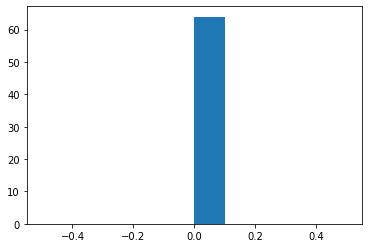

In [ ]:
plt.hist(batch_data[1], bins = 10)
plt.show()

In [ ]:
X_train, Y_Train = next(train_generator)

In [ ]:
Y_Train

array([-0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.03755869,
       -0.03755869,  0.03755869, -0.100939  ,  0.100939  ])

# **Dataset split**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.20, random_state = 1)

# **Building Neural Networks**

In [28]:
model1 = Sequential()
model1.add(Convolution2D(16, 3, 3, input_shape=(100, 320, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model1.add(Convolution2D(32, 3, 3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model1.add(Convolution2D(64, 3, 3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model1.add(core.Flatten())
model1.add(core.Dense(500, activation='relu'))
model1.add(core.Dropout(.5))
model1.add(core.Dense(100, activation='relu'))
model1.add(core.Dropout(.25))
model1.add(core.Dense(20, activation='relu'))
model1.add(core.Dense(1))
model1.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mse')

Model summary

In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 106, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 53, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 17, 32)         4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 9, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [30]:
callback1 = ModelCheckpoint('best_model.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback2 = EarlyStopping(patience=15)
callback_list = [callback1, callback2]

**Model training**

In [31]:
history = model1.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list,
        epochs=3)

Epoch 1/3
650/650 [==============================] - 978s 1s/step - loss: 4.2806 - val_loss: 0.0118

Epoch 00001: val_loss improved from inf to 0.01176, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
Epoch 2/3
650/650 [==============================] - 964s 1s/step - loss: 0.0820 - val_loss: 0.0022

Epoch 00002: val_loss improved from 0.01176 to 0.00223, saving model to best_model.pt
INFO:tensorflow:Assets written to: best_model.pt/assets
Epoch 3/3
650/650 [==============================] - 955s 1s/step - loss: 0.0321 - val_loss: 0.0100

Epoch 00003: val_loss did not improve from 0.00223


Text(0.5, 0, 'Epoch')

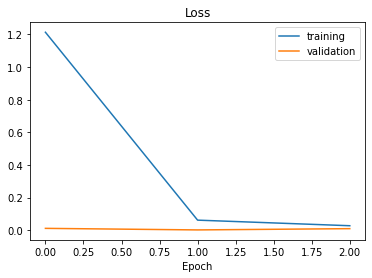

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [33]:
model1.save('model1.h5')

In [ ]:
model2 = Sequential()
model2.add(Convolution2D(24, 2, 2, input_shape=(160, 320, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(36, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(48, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Convolution2D(64, 2, 2, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model2.add(Dropout(0.5))

model2.add(core.Flatten())
model2.add(core.Dense(100, activation='relu'))
model2.add(core.Dropout(0.5))

model2.add(core.Dense(50, activation='relu'))
model2.add(core.Dropout(0.5))

model2.add(core.Dense(10, activation='relu'))
model2.add(core.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 160, 24)       312       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 80, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 40, 36)        3492      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 20, 36)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 10, 48)         6960      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 5, 48)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 2, 64)         

In [ ]:
callback12 = ModelCheckpoint('best_model_2.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback22 = EarlyStopping(patience=15)
callback_list_2 = [callback12, callback22]

In [ ]:
history_2 = model2.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_2,
        epochs=3)

Epoch 1/3
650/650 [==============================] - 931s 1s/step - loss: 8.6501 - val_loss: 0.0035

Epoch 00001: val_loss improved from inf to 0.00351, saving model to best_model_2.pt
INFO:tensorflow:Assets written to: best_model_2.pt/assets
Epoch 2/3
650/650 [==============================] - 932s 1s/step - loss: 0.0104 - val_loss: 0.0017

Epoch 00002: val_loss improved from 0.00351 to 0.00166, saving model to best_model_2.pt
INFO:tensorflow:Assets written to: best_model_2.pt/assets
Epoch 3/3
650/650 [==============================] - 876s 1s/step - loss: 0.0089 - val_loss: 3.5202e-04

Epoch 00003: val_loss improved from 0.00166 to 0.00035, saving model to best_model_2.pt
INFO:tensorflow:Assets written to: best_model_2.pt/assets


Text(0.5, 0, 'Epoch')

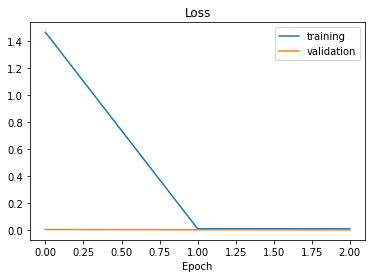

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [ ]:
lista = []
for i in range(len(X_test)+1):
  lista.append(read_image(X_test[i]))
  print(lista)

In [ ]:
print(tf.shape(lista).numpy())

[635 160 320   3]


In [ ]:
def image_preprocess_(image):
   image = mpimg.imread(image)
   image = image[60:, :, :]
   image = cv2.resize(image, (200, 66))
   image = image/255
   return image

In [ ]:
import matplotlib.image as mpimg
def image_preprocess_(image):
    image = read_image(image)
    image = mpimg.imread(image)
    return image

In [ ]:
slika = read_image(X_test[0])
slika = crop(slika)

In [ ]:
# plt.imshow(slika)
# plt.show()

print(slika.shape)

(100, 320, 3)


In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('model1.h5')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 53, 106, 16)       448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 53, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 17, 32)         4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 9, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

In [ ]:
print(slika.shape)
batch = print(slika[None, :, :, :].shape)
agol = model.predict(slika[None, :, :, :])
print(agol)

(100, 320, 3)
(1, 100, 320, 3)
[[0.04588937]]


In [ ]:
X_test1 = np.array(list(map(image_preprocess_, X_test)))

In [ ]:
len(lista)

635

In [ ]:
y_pred2 = model2.predict(t2)
trashold = 0.07
isaccurate = map(lambda x,y: 1 if x-y <= trashold else 0)
d = {'Original': [X_test], 'Predicted': [y_pred2], 'IsAccurate': [isaccurate]}
predicted2_df = pd.DataFrame(data = d, columns = ['Original', 'Predicted', 'Trashold'])

In [ ]:
print(classification_report(y_test, y_pred2))
print("Accuracy:",accuracy_score(y_test, y_pred2))

In [ ]:
model2.save('model2.h5')

In [ ]:
model3 = Sequential()
model3.add(Convolution2D (64, 3, 3, input_shape=(160, 320, 3), padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))

model3.add(Convolution2D (128, 3, 3, padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))

model3.add(Convolution2D (256, 3, 3, padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))

model3.add(Convolution2D (512, 3, 3, padding ='same', activation='elu'))
model3.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(1024, activation ='elu'))
model3.add(Dropout(0.5))

model3.add(Dense(1))

model3.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 54, 107, 64)       1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 54, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 18, 128)        73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 9, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 3, 256)         295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 2, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 512)        

In [ ]:
callback13 = ModelCheckpoint('best_model_3.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback23 = EarlyStopping(patience=15)
callback_list_3 = [callback13, callback23]

In [ ]:
history_3 = model3.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_3,
        epochs=10)

Epoch 1/10
56/56 [==============================] - 94s 2s/step - loss: 117.8006 - val_loss: 0.4759

Epoch 00001: val_loss improved from inf to 0.47589, saving model to best_model_3.pt
INFO:tensorflow:Assets written to: best_model_3.pt/assets
Epoch 2/10
56/56 [==============================] - 77s 1s/step - loss: 0.9744 - val_loss: 0.0445

Epoch 00002: val_loss improved from 0.47589 to 0.04452, saving model to best_model_3.pt
INFO:tensorflow:Assets written to: best_model_3.pt/assets
Epoch 3/10
56/56 [==============================] - 77s 1s/step - loss: 0.5123 - val_loss: 0.0445

Epoch 00003: val_loss did not improve from 0.04452
Epoch 4/10
56/56 [==============================] - 76s 1s/step - loss: 0.4080 - val_loss: 0.0256

Epoch 00004: val_loss improved from 0.04452 to 0.02565, saving model to best_model_3.pt
INFO:tensorflow:Assets written to: best_model_3.pt/assets
Epoch 5/10
56/56 [==============================] - 74s 1s/step - loss: 0.3406 - val_loss: 0.0133

Epoch 00005: val_l

Text(0.5, 0, 'Epoch')

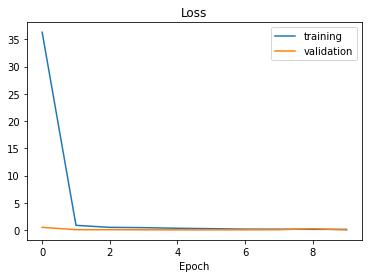

In [ ]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model3.save('model3.h5')

In [ ]:
model4 = Sequential()
model4.add(Convolution2D(24, 5, 5, input_shape = (160,320,3), activation='relu'))
model4.add(BatchNormalization())

model4.add(Convolution2D(36, 5, 5, activation='relu'))
model4.add(BatchNormalization())

model4.add(Convolution2D(64, 3, 3, activation='relu'))
model4.add(MaxPooling2D(pool_size =(2,2), strides =2, padding ='same'))
model4.add(BatchNormalization())
    
model4.add(Flatten())
    
model4.add(Dense(1164, activation='relu'))
model4.add(BatchNormalization())
    
model4.add(Dense(200, activation='relu'))
model4.add(BatchNormalization())
    
model4.add(Dense(50, activation='relu'))
model4.add(BatchNormalization())
    
model4.add(Dense(10, activation='relu'))
model4.add(BatchNormalization())
    
model4.add(Dense(1))
    
model4.compile(loss = "MSE", optimizer = Adam(learning_rate = 0.001))

In [ ]:
model4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 64, 24)        1824      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 64, 24)        96        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 6, 12, 36)         21636     
_________________________________________________________________
batch_normalization_19 (Batc (None, 6, 12, 36)         144       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 2, 4, 64)          20800     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 2, 64)          0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 1, 2, 64)        

In [ ]:
callback14 = ModelCheckpoint('best_model_4.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback24 = EarlyStopping(patience=15)
callback_list_4 = [callback14, callback24]

In [ ]:
history_4 = model4.fit(
        train_generator,
        steps_per_epoch = len(X_train)//32,
        validation_data  = valid_generator,
        validation_steps = len(X_test)//32,
        callbacks = callback_list_3,
        epochs=10)

Epoch 1/10
56/56 [==============================] - 85s 1s/step - loss: 0.8777 - val_loss: 0.3118

Epoch 00001: val_loss did not improve from 0.00472
Epoch 2/10
56/56 [==============================] - 72s 1s/step - loss: 0.1088 - val_loss: 0.5463

Epoch 00002: val_loss did not improve from 0.00472
Epoch 3/10
56/56 [==============================] - 72s 1s/step - loss: 0.0450 - val_loss: 0.4491

Epoch 00003: val_loss did not improve from 0.00472
Epoch 4/10
56/56 [==============================] - 74s 1s/step - loss: 0.0285 - val_loss: 0.2927

Epoch 00004: val_loss did not improve from 0.00472
Epoch 5/10
56/56 [==============================] - 74s 1s/step - loss: 0.0344 - val_loss: 0.2136

Epoch 00005: val_loss did not improve from 0.00472
Epoch 6/10
56/56 [==============================] - 73s 1s/step - loss: 0.0225 - val_loss: 0.0471

Epoch 00006: val_loss did not improve from 0.00472
Epoch 7/10
56/56 [==============================] - 72s 1s/step - loss: 0.0169 - val_loss: 0.0224

E

Text(0.5, 0, 'Epoch')

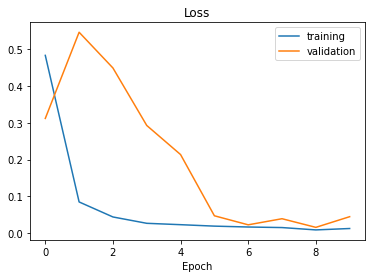

In [ ]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model4.save('model4.h5')